## 概要
- Poseを使った異常検知をMNISTでテストしてみる

## モジュールのインポート

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model, model_from_json
from io import BytesIO

from tqdm import tqdm_notebook as tqdm
import os
import socket

Using TensorFlow backend.


In [2]:
norm = Normalize(vmin=0, vmax=250)
cmap = cm.get_cmap("jet")
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable._A = []

In [3]:
color_m = np.array([np.ones((28,280,3)) * cm.jet((100-i)/100)[:3] for i in range(100)]).reshape(28 * 100,280, 3)

In [4]:
jet_color = np.array(cm.jet(np.random.rand(1)[0])[:3])# * 255
jet_color

array([0.        , 0.22156863, 1.        ])

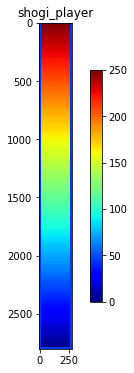

In [5]:
height, width = color_m.shape[:2]
plt.figure(figsize=(8, 6))
plt.imshow(color_m)
plt.title("shogi_player")
plt.imshow(cv2.rectangle(color_m, (0, 0), (width-1, height-1), jet_color, int(min(height, width)/10)))
plt.colorbar(mappable, fraction=0.026, pad=0.04)

## 棋譜の読み込み

In [6]:
isFujii = False

In [7]:
with open("../data/kif/AbemaTV_Tournament_Final1_analized.kif", encoding="utf-8") as f:
    kif = f.readlines()
shogi_df = pd.DataFrame([int(k.split(" ")[1]) for k in kif if "*##" in k], columns=["score"])

if not isFujii:# 後手番なら評価値を逆にする
    shogi_df["score"] = shogi_df["score"] * -1
shogi_df['score_label'] = shogi_df["score"].map(lambda x: x//300)
shogi_df["hand_number"] = shogi_df.index

## 関数や変数を読み込む

In [8]:
# openposeのやつ
from DeNAPose.pose_detector import PoseDetector, draw_person_pose

In [9]:
def extract_skelton(img, isFujii, pose_detector, pose_thresh):
    pose_rect = cv2.flip(img[678:968, 45:565].copy(), 1) if isFujii else img[220:510, 1340:1860].copy()

    pose_keypoints, scores = pose_detector(pose_rect)
    if len(np.where(scores > pose_thresh)[0]) == 0:
        # 真っ白な画像を作成
        img_skel = np.zeros_like(pose_rect)
    else:    
        img_skel = draw_person_pose(np.full_like(pose_rect, 255), pose_keypoints[np.where(scores > pose_thresh)])
        
        img_player = draw_person_pose(pose_rect, pose_keypoints[np.where(scores > pose_thresh)])
#         if isFujii:
#             pose_rect = cv2.filp(img_player, 1)
#         else:
#             pose_rect = img_player

    return img_player, img_skel

In [10]:
def preprocess(img):
    size = 32
  
    # openposeのミスをできるだけ前処理で落とす
    try:
        x, w, y, h = trimming(img)
        margin = 16
        img_trim = img[y-margin:h+margin, x-margin:w+margin]
        height, width = img_trim.shape
        
        if (height < 100) or (width < 100):
            return np.zeros((size, size))
        
        # 膨張処理
        kernel = np.ones((6,6),np.uint8)
        img_trim = cv2.bitwise_not(img_trim) # 白(255)を膨張させるため反転
        img_dil = cv2.dilate(img_trim,kernel,iterations = 1)
        
        img_dil = cv2.resize(img_dil, (size, size))
        
        # 2値化
        _,img_bin = cv2.threshold(img_dil,0,1,cv2.THRESH_BINARY)
        
        return img_bin * 255.0 
    except:
        return np.zeros((size, size))

In [11]:
def trimming(img):
    mask = img < 255
    x = np.where(np.sum(mask, axis=0) > 1)[0]
    y = np.where(np.sum(mask, axis=1) > 1)[0]
    
    x_min, x_max = x[0], x[-1]
    y_min, y_max = y[0], y[-1]
    return x_min, x_max, y_min, y_max

In [12]:
def output_to_bytes_decode_img():
    with BytesIO() as output:
        func()
        plt.close()
        image_string = output.getvalue()
    img_array = np.fromstring(image_string, np.uint8)
    img_graph = cv2.imdecode(img_array, 1)

In [13]:
def make_player(img, mappable, img_diff):
    height, width = img.shape[:2]
    jet_color = np.array(cm.jet(img_diff/250)[:3])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with BytesIO() as output:
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title("shogi_player")
        plt.imshow(cv2.rectangle(img, (0, 0), (width-1, height-1), jet_color * 255, int(min(height, width)/10)))
        plt.colorbar(mappable, fraction=0.026, pad=0.04)
        plt.savefig(output, format="PNG")
        plt.close()
        image_string = output.getvalue()
    img_array = np.fromstring(image_string, np.uint8)
    img_player = cv2.imdecode(img_array, 3)
    
    return img_player

In [1]:
def make_graph_img(x_smooth, y_smooth, t):
    with BytesIO() as output:
        plt.figure(figsize=(8,6))
        plt.plot(x_smooth/10, y_smooth, label="difference images")
        plt.hlines(17, 0, scores_df.shape[0]//10, label="threshold")
        plt.plot(t, y_smooth[t], "ro", markersize=4)        
        plt.title("difference from original & predict images")
        plt.xlabel("Time(s)")
        plt.ylabel("Abnormaly Level(smoothing)")
        plt.legend()
        plt.savefig(output, format="PNG")
        plt.close()
        image_string = output.getvalue()
    img_array = np.fromstring(image_string, np.uint8)
    img_graph = cv2.imdecode(img_array, 3)
    
    return img_graph

In [15]:
def make_compare_pose(img_orig, img_pred):
    with BytesIO() as output:
        fig, ax = plt.subplots(ncols=2, figsize=(5, 3))
        for i, (img, title) in enumerate(zip([img_orig, img_pred], ["original", "prediction"])):  
            ax[i].imshow(img, cmap="gray")
            ax[i].set_title(title)
        plt.savefig(output, format="PNG")
        plt.close()
        image_string = output.getvalue()
    img_array = np.fromstring(image_string, np.uint8)
    img_pose = cv2.imdecode(img_array, 3)
    
    return img_pose

## 動画に対してリアルタイムに評価する

In [16]:
import time

In [17]:
def main(cap):
    pose_thresh = 5 # openposeによるスケルトン抽出時の信頼度スコアのしきい値
    sampling_frame_rate = 6
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//sampling_frame_rate

    # ヒートマップ用初期パラメータ
    norm = Normalize(vmin=0, vmax=250)
    cmap = cm.get_cmap("jet")
    mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable._A = []
    
    # 転送用設定
#     s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#     s.bind(("10.0.2.159", 9898))
#     print("Waiting...")
#     s.listen(1)
#     soc_cli, addr = s.accept()
#     print("Connected {}".format(addr))
    
#     soc_sev = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#     soc_sev.connect(("10.0.2.163", 8989))
#     print("Connected")

    fourcc = cv2.VideoWriter_fourcc("m","p","4","v")
    video = cv2.VideoWriter("../abnormal_pose_detection_result.mp4", fourcc, 20.0, (720, 480))
    
    # openposeモデルの読み込み
    pose_detector = PoseDetector("posenet", "../utils/DeNAPose/models/coco_posenet.npz", device=0)
    
    # アーキテクチャの読み込み
    with open("../output/conv_vae_model_20190107_074233.json") as f:
        json_string = f.readline()

    vae = model_from_json(json_string)
    vae.load_weights("../output/conv_vae_best_param_20190107_074233.hdf5")
    
    #while cap.isOpened():
    for i in tqdm(range(total)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, sampling_frame_rate*i)
        # 動画用に書き出すデータを1枚のcanvasにまとめる
        canvas = np.ones((480, 720, 3), np.uint8) * 255
        h_canvas, w_canvas = canvas.shape[:2]
        
        frame = cap.read()[1]
        try:
            img_orig, img_skelton = extract_skelton(frame, False, pose_detector, pose_thresh)
        except:
            continue
        del frame
        img_pose = preprocess(cv2.cvtColor(img_skelton, cv2.COLOR_RGB2GRAY)) / 255
        del img_skelton
        
        h, w = img_pose.shape
        img_pose = img_pose.reshape(1, h, w, 1)
        img_pred = vae.predict(img_pose)[0].reshape(32,32)
        img_pose = img_pose[0].reshape(32,32)
        
        img_diff = np.sum(np.abs(img_pose - img_pred))
        
        # openpose結果の出力
        #img_heat = cv2.cvtColor(make_player(img_orig, mappable, img_diff), cv2.COLOR_BGR2RGB)
        img_heat = make_player(img_orig, mappable, img_diff)
        del img_orig
        x, w, y, h = trimming(img_heat)
        img_heat = img_heat[y-16:h+16, x-16:w+16]
        h_orig, w_orig = img_heat.shape[:2]

        canvas[0:h_orig, 0:w_orig] = img_heat
        
        # 対局中の局面評価を出力
#         img_graph = make_graph_img(,i)

#         h_result = h_canvas - img_heat.shape[0]
#         h_graph, w_graph = img_graph.shape[:2]
#         rate = round(h_result / h_graph, 2)
#         img_graph = cv2.resize(img_graph.copy(), (int(w_graph*rate), h_result))
#         h_graph, w_graph = img_graph.shape[:2]

#         canvas[h_canvas - h_graph:h_canvas, 0:w_graph] = img_graph
#         del img_graph
        
        # 入力データと予測データの比較画像を出力
        img_compare = make_compare_pose(img_pose, img_pred)
        del img_pose, img_pred

        x, w, y, h = trimming(cv2.cvtColor(img_compare, cv2.COLOR_BGR2GRAY))
        img_compare = img_compare[y-16:h+16, x-16:w+16]
        h_comp, w_comp = img_compare.shape[:2]

        #canvas[h_canvas - h_graph - 3:h_canvas, w_graph:w_graph + img_compare.shape[1]] = img_compare
        canvas[h_canvas - h_comp:h_canvas, 0:w_comp] = img_compare
        
        video.write(canvas)
        # サーバーへ転送
        #canvas_string = canvas.tostring()
        #soc_cli.send(canvas_string)
        del canvas
        #del canvas_string
        del img_heat
        del img_compare
        
        #soc_sev.recv(4096)

In [ ]:
cap = cv2.VideoCapture("../data/final1_labeling.mp4")
main(cap)

Loading the model...


/home/nvidia/Desktop/Research/utils/DeNAPose/pose_detector.py:147: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  paf_in_edge = np.hstack([paf[0][np.hsplit(integ_points, 2)], paf[1][np.hsplit(integ_points, 2)]])
/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.
